## Predict churn at lv 10

In [12]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

project_id = 'royal-hexa-in-house'

from google.cloud import bigquery

# Initialize the BigQuery client
client = bigquery.Client(project=project_id)

In [3]:
query = """
with user_finish_level_6 as (
  select 
    user_pseudo_id
  from `royal-hexa-in-house.dung_dinner_flatten.win_level`
  where level = 6 and event_date <= '2025-04-30' 
and user_pseudo_id in (select distinct user_pseudo_id from `royal-hexa-in-house.dung_dinner_flatten.first_open`)
),
new_user as (
  select 
    user_pseudo_id,
    case 
      when country in ('United Kingdom', 'Canada', 'United States', 'Austria') then 'Good'
      when country in ('New Zealand', 'Netherlands', 'South Korea', 'Germany', 'Japan') then 'Average' 
      else 'Bad'
    end as country_cluster,
    case
      when operating_system_version in ('Android 13', 'Android 14', 'Android 14.0', 'Android 15', 'Android 16', 'Android 12', 'Android 12.0') then 'Good'
      when operating_system_version in ('Android 10', 'Android 11.0') then 'Average'
      else 'Bad'
    end as device_cluster,
    event_timestamp as first_open_time
  from `royal-hexa-in-house.dung_dinner_flatten.first_open`
  where user_pseudo_id in (select distinct user_pseudo_id from user_finish_level_6)
),

time_to_level_6 as (
  select 
    user_pseudo_id,
    sum(time_minute) as time_to_reach_level_6
  from `royal-hexa-in-house.dung_dinner_flatten.level_time`
  where level <= 6
  group by user_pseudo_id
),
session_to_level_6 as (
  select 
    user_pseudo_id,
    ga_session_number as num_session_to_reach_level_6
  from `royal-hexa-in-house.dung_dinner_flatten.win_level`
  where level = 6
),

rewards_count as (
  select
    user_pseudo_id,
    count(*) as num_rw_to_win_level_6
  from `royal-hexa-in-house.dung_dinner_flatten.level_adreward`
  where level <= 6
  group by user_pseudo_id
), 
 finished_level_10 as (
select distinct user_pseudo_id
from `royal-hexa-in-house.dung_dinner_flatten.win_level`
where level = 10
and user_pseudo_id in (select distinct user_pseudo_id from user_finish_level_6)
)
select
  w.user_pseudo_id,
  n.device_cluster,
  n.country_cluster,
  t.time_to_reach_level_6,
  s.num_session_to_reach_level_6,
  coalesce(r.num_rw_to_win_level_6, 0) as num_rw_to_win_level_6,
  case 
    when w.user_pseudo_id in (select distinct user_pseudo_id from finished_level_10) then 'not_churn'
    when w.user_pseudo_id in (select distinct user_pseudo_id from user_finish_level_6) and w.user_pseudo_id not in (select distinct user_pseudo_id from finished_level_10) then 'churn'
    else null
  end as is_churn
from `royal-hexa-in-house.dung_dinner_flatten.win_level` w
join new_user n on w.user_pseudo_id = n.user_pseudo_id
left join time_to_level_6 t on w.user_pseudo_id = t.user_pseudo_id
left join session_to_level_6 s on w.user_pseudo_id = s.user_pseudo_id
left join rewards_count r on w.user_pseudo_id = r.user_pseudo_id
where w.level = 6 and w.user_pseudo_id in (select distinct user_pseudo_id from user_finish_level_6)
""" 

df = client.query(query).to_dataframe()
df 

c:\Users\dungv\Downloads\Adone_Trainning\DS06\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,user_pseudo_id,device_cluster,country_cluster,time_to_reach_level_6,num_session_to_reach_level_6,num_rw_to_win_level_6,is_churn
0,16068f6688ac792742f37b3504562992,Good,Bad,23.233333,1,14,not_churn
1,1c759ea087daaafbaffd58c429e9f2ed,Good,Bad,67.033333,3,80,not_churn
2,5a662ba338894b7de4497bbe7b799ed2,Good,Bad,23.700000,1,16,churn
3,54230c2d61f01ad94271a6893acc773a,Bad,Average,30.200000,1,14,not_churn
4,b672093d1f4253cb0d4bb7fb5ae20c12,Good,Good,46.083333,1,15,not_churn
...,...,...,...,...,...,...,...
44111,3b2c26ffb02c44cf2777e42ed144f06c,Good,Average,47.350000,1,12,churn
44112,916a1dabc4cc42190bd6acc9ced8ff9e,Average,Bad,16.916667,2,12,churn
44113,6faef2fc38ec78412cef6ef47b02d613,Good,Bad,38.466667,4,12,churn
44114,6e0d29fe86a6abb4616c983dbe56d11d,Good,Bad,46.266667,1,12,churn


In [14]:
query = """ 
select distinct user_pseudo_id, level, day from `royal-hexa-in-house.dung_dinner_flatten.level_end_day`
where level is not null and day is not null
and user_pseudo_id in 
(select distinct user_pseudo_id from `royal-hexa-in-house.dung_dinner_flatten.win_level` where level = 6 
 and event_date <= '2025-04-30' 
and user_pseudo_id in (select distinct user_pseudo_id from `royal-hexa-in-house.dung_dinner_flatten.first_open`))
"""
end_day = client.query(query).to_dataframe()
# Create a new dataframe with max days for each level per user
level_6_days = end_day[end_day['level'] == 6].groupby('user_pseudo_id')['day'].max().reset_index()
level_6_days.columns = ['user_pseudo_id', 'level_6']

days_to_end

KeyboardInterrupt: 

In [4]:
df['is_churn'].value_counts()

is_churn
churn        23391
not_churn    20725
Name: count, dtype: int64

In [5]:
# Replace device_cluster values
df['device_cluster'] = df['device_cluster'].replace({'Good': 2, 'Average': 1, 'Bad': 0})

# Replace country_cluster values 
df['country_cluster'] = df['country_cluster'].replace({'Good': 2, 'Average': 1, 'Bad': 0})

df

C:\Users\dungv\AppData\Local\Temp\ipykernel_12536\3718813409.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['device_cluster'] = df['device_cluster'].replace({'Good': 2, 'Average': 1, 'Bad': 0})
C:\Users\dungv\AppData\Local\Temp\ipykernel_12536\3718813409.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['country_cluster'] = df['country_cluster'].replace({'Good': 2, 'Average': 1, 'Bad': 0})


,user_pseudo_id,device_cluster,country_cluster,time_to_reach_level_6,num_session_to_reach_level_6,num_rw_to_win_level_6,is_churn
0,16068f6688ac792742f37b3504562992,2,0,23.233333,1,14,not_churn
1,1c759ea087daaafbaffd58c429e9f2ed,2,0,67.033333,3,80,not_churn
2,5a662ba338894b7de4497bbe7b799ed2,2,0,23.700000,1,16,churn
3,54230c2d61f01ad94271a6893acc773a,0,1,30.200000,1,14,not_churn
4,b672093d1f4253cb0d4bb7fb5ae20c12,2,2,46.083333,1,15,not_churn
...,...,...,...,...,...,...,...
44111,3b2c26ffb02c44cf2777e42ed144f06c,2,1,47.350000,1,12,churn
44112,916a1dabc4cc42190bd6acc9ced8ff9e,1,0,16.916667,2,12,churn
44113,6faef2fc38ec78412cef6ef47b02d613,2,0,38.466667,4,12,churn
44114,6e0d29fe86a6abb4616c983dbe56d11d,2,0,46.266667,1,12,churn


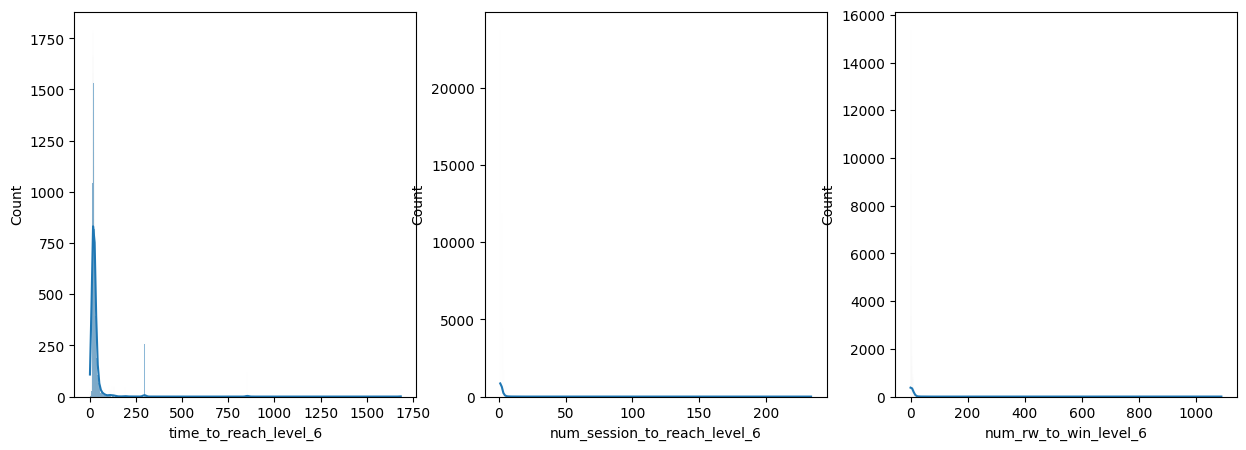

In [6]:
# Tắt tất cả các cảnh báo
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Vẽ phân phối
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(df['time_to_reach_level_6'], kde=True, ax=axs[0])
sns.histplot(df['num_session_to_reach_level_6'], kde=True, ax=axs[1])
sns.histplot(df['num_rw_to_win_level_6'], kde=True, ax=axs[2])

# Hiển thị biểu đồ
plt.show()

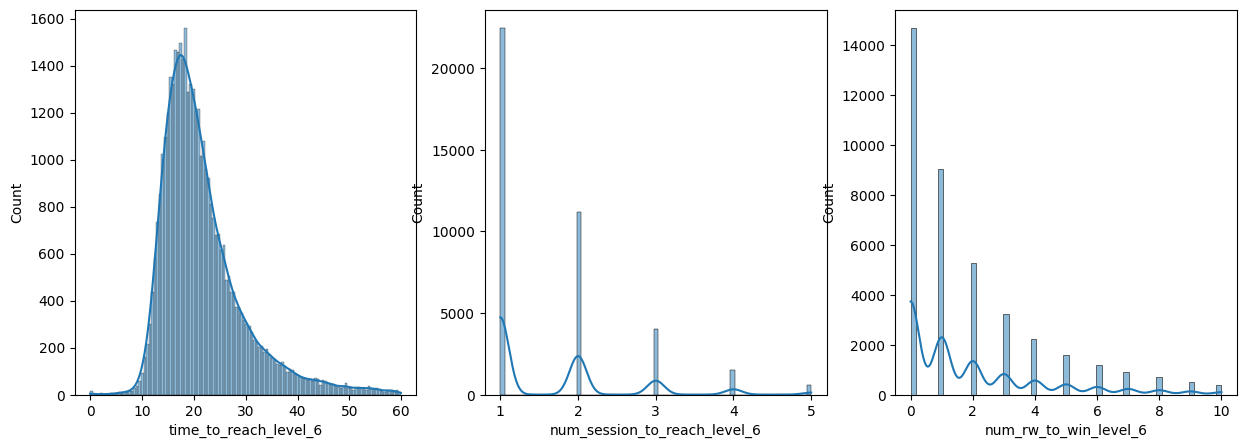

In [7]:
df1 = df.copy()
# lọc ouliner 
df1 = df1[df1['time_to_reach_level_6'] <= 60]
df1 = df1[df1['num_session_to_reach_level_6'] <= 5 ]
df1 = df1[df1['num_rw_to_win_level_6'] <= 10 ]
# Tắt tất cả các cảnh báo
warnings.filterwarnings('ignore')

# Vẽ phân phối
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(df1['time_to_reach_level_6'], kde=True, ax=axs[0])
sns.histplot(df1['num_session_to_reach_level_6'], kde=True, ax=axs[1])
sns.histplot(df1['num_rw_to_win_level_6'], kde=True, ax=axs[2])

# Hiển thị biểu đồ
plt.show()

In [8]:
df1['is_churn'].value_counts()

is_churn
churn        21576
not_churn    18222
Name: count, dtype: int64

In [10]:
# Split features and target
X = df1.drop(['is_churn', 'user_pseudo_id'], axis=1) # Drop user_pseudo_id since it's not a meaningful feature
y = df1['is_churn']

# Convert target to binary
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
le = LabelEncoder()
y = le.fit_transform(y)

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



In [11]:

# Use LazyPredict to compare multiple models
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models_train, predictions_train = clf.fit(X_train, X_test, y_train, y_test)

# Print model comparison results
print("Model Performance Comparison:")
print(models_train)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 14536, number of negative: 17302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 281
[LightGBM] [Info] Number of data points in the train set: 31838, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.456561 -> initscore=-0.174194
[LightGBM] [Info] Start training from score -0.174194
Model Performance Comparison:
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.55               0.56     0.56      0.55   
LGBMClassifier                     0.57               0.55     0.55      0.54   
QuadraticDiscriminantAnalysis      0.56               0.55     0.55      0.54   
GaussianN